# atoti demonstration

### Key purpose of demonstration
- How to implement basic security 
    - Control on data level
    - Control on dashboard level
    - Control on application level
- Integration with MS SQL
- Creation of date hierarchy to provide aggregated summary on different date parts
- Real-time dataloading and dashboarding
- What-if with source simulation 

In [1]:
from datetime import date, datetime, timedelta

import atoti as tt
import polling
from util import mockML

## Security  

We will create the followings:
- roles with rules to access of data
- users with roles to apply control over type of acccess

Type of users:
- manager_fr
- manager_de
- market_manager_eu
- market_manager_us
- general_manager
- admin_user

https://docs.atoti.io/latest/lib/atoti-plus/atoti_plus.security.html#atoti_plus.security.Security

In [2]:
session = tt.create_session(
    "Sales",
    config={
        "user_content_storage": "./content",
        "authentication": {"basic": {"realm": "Test security"}},
        "port": 9091,
    },
)

In [3]:
session.security.create_role(
    "ROLE_EU_FR",
    restrictions={
        "HOSPITAL_ID": [
            "FR_HOSP_1",
            "FR_HOSP_2",
            "FR_HOSP_3",
            "FR_HOSP_4",
            "FR_HOSP_5",
            "FR_HOSP_6",
            "FR_HOSP_7",
            "FR_HOSP_8",
            "FR_HOSP_9",
            "FR_HOSP_10",
        ]
    },
)

session.security.create_role(
    "ROLE_EU_DE",
    restrictions={
        "HOSPITAL_ID": [
            "DE_HOSP_1",
            "DE_HOSP_2",
            "DE_HOSP_3",
            "DE_HOSP_4",
            "DE_HOSP_5",
            "DE_HOSP_6",
            "DE_HOSP_7",
            "DE_HOSP_8",
            "DE_HOSP_9",
            "DE_HOSP_10",
        ]
    },
)

session.security.create_role(
    "ROLE_MARKET_EU", restrictions={"COUNTRY": ["FRANCE", "GERMANY"]}
)

session.security.create_role("ROLE_MARKET_US", restrictions={"COUNTRY": ["USA"]})

Role(name='ROLE_MARKET_US', restrictions=Restrictions())

In [4]:
session.security.basic.create_user(
    "admin_user", password="admin_password", roles=["ROLE_ADMIN", "ROLE_SHARE"]
)

User(username='admin_user', roles=UserRoles(), _type='BASIC')

In [5]:
session.security.basic.create_user(
    "manager_fr", password="m1_password", roles=["ROLE_EU_FR"]
)

session.security.basic.create_user(
    "manager_de", password="m2_password", roles=["ROLE_EU_DE"]
)

session.security.basic.create_user(
    "market_manager_eu",
    password="eu_password",
    roles=["ROLE_MARKET_EU", "ROLE_SHARE"],
)

session.security.basic.create_user(
    "market_manager_us", password="us_password", roles=["ROLE_MARKET_US", "ROLE_SHARE"]
)

session.security.basic.create_user(
    "general_manager", password="gm_password", roles=["ROLE_USER", "ROLE_SHARE"]
)

User(username='general_manager', roles=UserRoles(), _type='BASIC')

In [6]:
session.security.basic.users.items()

dict_items([('manager_fr', User(username='manager_fr', roles=UserRoles(), _type='BASIC')), ('general_manager', User(username='general_manager', roles=UserRoles(), _type='BASIC')), ('manager_de', User(username='manager_de', roles=UserRoles(), _type='BASIC')), ('market_manager_us', User(username='market_manager_us', roles=UserRoles(), _type='BASIC')), ('market_manager_eu', User(username='market_manager_eu', roles=UserRoles(), _type='BASIC')), ('admin_user', User(username='admin_user', roles=UserRoles(), _type='BASIC'))])

## Read data from MS SQL

In [7]:
# to keep track of last polling time
last_poll_time = datetime.today()

sales_table = session.read_csv(
    "data/medical_sales_db.csv",
    table_name="Sales",
    keys=["SALE_ID", "SALE_DATE", "EQUIPMENT_ID"],
)

In [8]:
sales_table.head()

DEPARTMENT  QTY  UNIT_COST  \
SALE_DATE  SALE_ID    EQUIPMENT_ID                                           
2021-09-10 M000002771 E0033                           WARD    2      10.87   
2021-04-01 M000000001 E0133                       EYE UNIT    2     144.93   
2021-09-10 M000002771 E0044                            ICU    1    6723.52   
                      E0278           OCCUPATIONAL THERAPY    3      14.49   
                      E0301         ORTHOPAEDIC TECHNOLOGY    1      18.12   

                                   HOSPITAL_ID         LAST_UPDATE_DATE  
SALE_DATE  SALE_ID    EQUIPMENT_ID                                       
2021-09-10 M000002771 E0033         FR_HOSP_10  2021-09-10 13:50:50.127  
2021-04-01 M000000001 E0133          US_HOSP_1  2021-04-01 11:43:43.677  
2021-09-10 M000002771 E0044         FR_HOSP_10  2021-09-10 13:50:50.127  
                      E0278         FR_HOSP_10  2021-09-10 13:50:50.127  
                      E0301         FR_HOSP_10  2021-09-10 13:50:50.127

In [9]:
print(
    f"number of rows: {len(sales_table)}, number of columns: {len(sales_table.columns)}"
)

number of rows: 26988, number of columns: 8


In [10]:
sales_table

Table(_name='Sales', _scenario='Base', _columns={'DEPARTMENT': Column(name='DEPARTMENT', data_type=DataType(java_type='string', nullable=False)), 'QTY': Column(name='QTY', data_type=DataType(java_type='int', nullable=True)), 'EQUIPMENT_ID': Column(name='EQUIPMENT_ID', data_type=DataType(java_type='string', nullable=False)), 'UNIT_COST': Column(name='UNIT_COST', data_type=DataType(java_type='double', nullable=True)), 'SALE_ID': Column(name='SALE_ID', data_type=DataType(java_type='string', nullable=False)), 'SALE_DATE': Column(name='SALE_DATE', data_type=DataType(java_type='LocalDate', nullable=False)), 'HOSPITAL_ID': Column(name='HOSPITAL_ID', data_type=DataType(java_type='string', nullable=False)), 'LAST_UPDATE_DATE': Column(name='LAST_UPDATE_DATE', data_type=DataType(java_type='string', nullable=False))})

In [11]:
cube = session.create_cube(sales_table, "sales cube")

In [12]:
session.visualize("Equipment sales for 2021-09-22")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [13]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

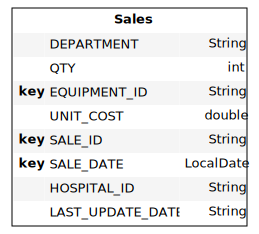

In [14]:
cube.schema

In [15]:
cube

Cube(_name='sales cube', _hierarchies=Hierarchies(), _measures=Measures())

In [16]:
m["Unit Cost"] = tt.value(sales_table["UNIT_COST"])

In [17]:
m["Sales amount"] = tt.agg.sum(
    m["QTY.SUM"] * m["Unit Cost"],
    scope=tt.scope.origin(l["EQUIPMENT_ID"], l["SALE_ID"], l["DEPARTMENT"]),
)

In [18]:
session.visualize("Sales amount for 2021-09-22")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Creating date parts (M, Y, d) 
https://docs.atoti.io/latest/lib/atoti.experimental.html#atoti.experimental.create_date_hierarchy

In [19]:
tt.experimental.create_date_hierarchy(
    "Quarterly",
    cube=cube,
    column=sales_table["SALE_DATE"],
    levels={"Year": "Y", "Quarter": "QQQ", "Month": "MM"},
)

In [20]:
tt.experimental.create_date_hierarchy(
    "Weekly",
    cube=cube,
    column=sales_table["SALE_DATE"],
    levels={"Year": "Y", "Month": "MM", "Week": "w", "Week Dtl": "(Y-MM) W"},
)

In [21]:
tt.experimental.create_date_hierarchy(
    "Date parts",
    cube=cube,
    column=sales_table["SALE_DATE"],
    levels={"Year": "Y", "Month": "MM", "Day": "dd"},
)

In [22]:
tt.experimental.create_date_hierarchy(
    "Year to Date",
    cube=cube,
    column=sales_table["SALE_DATE"],
    levels={"Year": "Y", "Date": "Y-MM-dd"},
)

In [23]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Loading product and shop details

In [24]:
device_table = session.read_csv(
    "data/medical_devices_db.csv",
    table_name="Devices",
    keys=["EQUIPMENT_ID"],
)

In [25]:
device_table.head()

,EQUIPMENT,PURCHASE_PRICE
EQUIPMENT_ID,,
E0004,Chest tubes,4.31
E0000,Thermometer clinical,1.01
E0001,"Intubation tubes, assorted sizes",2.50
E0002,Pedal Pins,2.88
E0003,Stethoscope,4.52


In [26]:
hospital_table = session.read_sql(
    "SELECT * FROM [atoti].[atoti].[hospitals];",
    url="jdbc:sqlserver://localhost:1433;databaseName=atoti;user=atoti;password=atoti2",
    table_name="Hospital",
    keys=["HOSPITAL_ID"],
)

In [27]:
hospital_table.head()

,COUNTRY,CITY
HOSPITAL_ID,,
US_HOSP_1,USA,NEW YORK
US_HOSP_3,USA,NEW YORK
US_HOSP_5,USA,LOS ANGELES
US_HOSP_7,USA,CHICAGO
US_HOSP_9,USA,CHICAGO


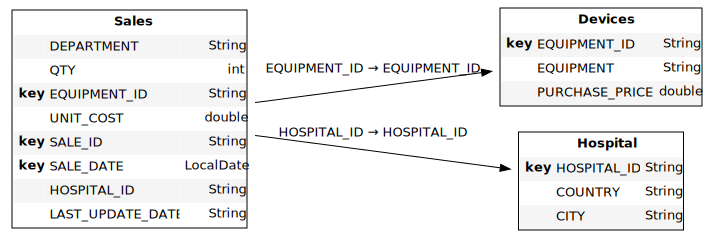

In [28]:
sales_table.join(device_table)
sales_table.join(hospital_table)
cube.schema

In [29]:
# creating multilevel hierarchy
h["LOCATION"] = [l["COUNTRY"], l["CITY"]]

In [30]:
session.visualize("Sales amount by location")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [31]:
session.visualize("Sales per equipment by country")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Sample measures creation

In [32]:
m["Purchase price"] = tt.value(
    device_table["PURCHASE_PRICE"], levels=[l["EQUIPMENT"], l["EQUIPMENT_ID"]]
)

In [33]:
m["Cost price"] = tt.agg.sum(
    m["QTY.SUM"] * m["Purchase price"],
    scope=tt.scope.origin(l["EQUIPMENT_ID"], l["SALE_ID"], l["DEPARTMENT"]),
)

In [34]:
m["Margin"] = m["Sales amount"] - m["Cost price"]

In [35]:
m["Margin rate"] = m["Margin"] / m["Sales amount"]
# m["Margin rate"].formatter = "DOUBLE[0.000%]"

In [36]:
m["Hospital count"] = tt.agg.count_distinct(hospital_table["HOSPITAL_ID"])

In [37]:
m["Quarterly cumulative margin"] = tt.agg.sum(
    m["Margin"], scope=tt.scope.cumulative(l["Quarter"])
)

m["Monthly cumulative margin"] = tt.agg.sum(
    m["Margin"], scope=tt.scope.cumulative(cube.levels[("Sales", "Quarterly", "Month")])
)

m["Weekly cumulative margin"] = tt.agg.sum(
    m["Margin"], scope=tt.scope.cumulative(l["Week Dtl"])
)

m["Daily cumulative margin"] = tt.agg.sum(
    m["Margin"], scope=tt.scope.cumulative(l["SALE_DATE"])
)

In [38]:
m["Quarterly cumulative margin"].folder = "Cumulative"
m["Monthly cumulative margin"].folder = "Cumulative"
m["Weekly cumulative margin"].folder = "Cumulative"
m["Daily cumulative margin"].folder = "Cumulative"

In [39]:
session.visualize("Sales trend")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [40]:
session.visualize("Sales trend")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [41]:
session.visualize("Difference in margin from previous quarter")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Accessing web application

In [42]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.